## Image captioning

Image captioning is the task of predicting a caption for a given image. Common real world applications of it include aiding visually impaired people that can help them navigate through different situations. Therefore, image captioning helps to improve content accessibility for people by describing images to them.


In [1]:
from datasets import load_dataset

# Load the 'image-caption-blip-for-training' dataset from the 'JerryMo' repository on the Hugging Face datasets hub
dataset = load_dataset("JerryMo/image-caption-blip-for-training")

# Display the loaded dataset
dataset


Generating train split:   0%|          | 0/2485 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 2485
    })
})

In [2]:
dataset = dataset['train']
dataset[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480>,
 'text': 'a family scene in the simpsons animated tv, The Simpsons'}

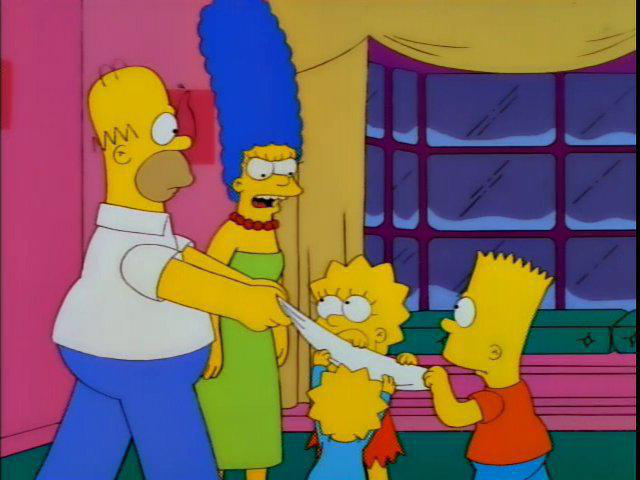

In [3]:
dataset[0]['image']

# Preprocess the dataset

Since the dataset has two modalities (image and text), the pre-processing pipeline will preprocess images and the captions.

To do so, load the processor class associated with the model you are about to fine-tune.

In [9]:
from transformers import AutoProcessor

# Define the model checkpoint for the processor
checkpoint = "microsoft/git-base"

# Load the processor from the specified pretrained model checkpoint
processor = AutoProcessor.from_pretrained(checkpoint)

The processor will internally pre-process the image (which includes resizing, and pixel scaling) and tokenize the caption.

In [10]:
def transforms(example_batch):
    """
    Apply transformations to a batch of examples by processing images and captions.
    
    :param example_batch: A batch of examples containing images and text captions.
    :return: A dictionary of processed inputs with labels.
    """
    # Extract images from the example batch
    images = [x for x in example_batch["image"]]
    
    # Extract captions from the example batch
    captions = [x for x in example_batch["text"]]
    
    # Process the images and captions using the processor
    inputs = processor(images=images, text=captions, padding="max_length")
    
    # Update the inputs dictionary to include labels (input IDs)
    inputs.update({"labels": inputs["input_ids"]})
    
    return inputs

# Set the transform function to be applied to the dataset
dataset.set_transform(transforms)


## Load a base model 

In [11]:
from transformers import AutoModelForCausalLM

# Load a pretrained causal language model from the specified checkpoint
model = AutoModelForCausalLM.from_pretrained(checkpoint)

## Evaluate 

Image captioning models are typically evaluated with the Rouge Score or Word Error Rate. For this guide, you will use the Word Error Rate (WER).

In [12]:
from evaluate import load
import torch

# Load the Word Error Rate (WER) metric from the 'evaluate' library
wer = load("wer")

def compute_metrics(eval_pred):
    """
    Compute evaluation metrics, specifically the Word Error Rate (WER), for the model predictions.

    :param eval_pred: A tuple containing logits and labels from the model evaluation.
    :return: A dictionary with the computed WER score.
    """
    # Unpack logits and labels from the evaluation predictions
    logits, labels = eval_pred
    
    # Get the predicted token indices by taking the argmax over the last dimension of logits
    predicted = logits.argmax(-1)
    
    # Decode the labels and predictions to text, skipping special tokens
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
    
    # Compute the WER score using the decoded predictions and labels
    wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
    
    # Return the WER score in a dictionary
    return {"wer_score": wer_score}


## Train

In [13]:
from transformers import TrainingArguments, Trainer

# Extract the model name from the checkpoint string
model_name = checkpoint.split("/")[1]

# Define the training arguments for the Trainer
training_args = TrainingArguments(
    output_dir=f"{model_name}-simson",        # Output directory for model checkpoints and logs
    learning_rate=5e-5,                       # Learning rate for training
    num_train_epochs=30,                      # Number of training epochs
    fp16=True,                                # Use 16-bit (mixed) precision training
    per_device_train_batch_size=16,           # Batch size per device (GPU/TPU) during training
    gradient_accumulation_steps=2,            # Number of updates steps to accumulate before performing a backward/update pass
    save_total_limit=3,                       # Limit the total amount of checkpoints, deletes the older checkpoints
    save_strategy="steps",                    # Save model checkpoint strategy (either "steps" or "epoch")
    save_steps=50,                            # Save model checkpoint every 50 steps
    logging_steps=50,                         # Log training information every 50 steps
    remove_unused_columns=False,              # Keep all columns in the dataset (don't remove unused columns)
    label_names=["labels"],                   # List of keys in your dictionary of inputs that correspond to the labels
)


In [14]:
# Initialize the Trainer
trainer = Trainer(
    model=model,                              # The model to be trained
    args=training_args,                       # The training arguments
    train_dataset=dataset,                    # The dataset to be used for training
    compute_metrics=compute_metrics,          # The function to compute metrics during evaluation
)

/home/work/.conda/envs/huggingface/lib/python3.10/site-packages/accelerate/accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [15]:
trainer.train()

Step,Training Loss
50,7.305100
100,2.081500
150,0.100500
200,0.045600


KeyboardInterrupt: 

## Inference 

In [ ]:
from PIL import Image
import requests

url = "https://visla.kr/wp/wp-content/uploads/2023/11/231106_02.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

In [ ]:
generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)